In [1]:
import numpy as np
from copy import copy

import pandas as pd
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
users = pd.read_excel("data/Dataset.xlsx", sheet_name="User Profile Matrix", engine="openpyxl")
users = users.rename(columns={col: col.lower().replace(" ", "_") for col in users.columns})

ratings = pd.read_excel("data/Dataset.xlsx", sheet_name="LU Rating Matrix", engine="openpyxl")
ratings = ratings.rename(columns={"Unnamed: 0": "course"})
ratings = ratings.melt(id_vars=["course"], var_name="username", value_name="rating")
ratings = ratings.dropna(subset=("rating", ))
ratings = pd.merge(ratings, users, on="username")

ratings.head()

course  \
0                Social Media Guidelines Online Kurs   
1                            Überzeugend Formulieren   
2                         Change Management Training   
3                                   Prozesse steuern   
4  Stephan Grabmaier – Wir müssen ins Handeln kommen   

                           username  rating  \
0  maria.franke@peers-solutions.com     2.5   
1  maria.franke@peers-solutions.com     3.5   
2  maria.franke@peers-solutions.com     4.0   
3  maria.franke@peers-solutions.com     1.0   
4  maria.franke@peers-solutions.com     3.0   

                                         job_title  \
0  Financial Risk Analyst/Financial Risk Analystin   
1  Financial Risk Analyst/Financial Risk Analystin   
2  Financial Risk Analyst/Financial Risk Analystin   
3  Financial Risk Analyst/Financial Risk Analystin   
4  Financial Risk Analyst/Financial Risk Analystin   

                                industry  position department  
0  Finanzen, Versicherungen & Immobilien  Employee   Vertrieb  
1  Finanzen, Versicherungen & Immobilien  Employee   Vertrieb  
2  Finanzen, Versicherungen & Immobilien  Employee   Vertrieb  
3  Finanzen, Versicherungen & Immobilien  Employee   Vertrieb  
4  Finanzen, Versicherungen & Immobilien  Employee   Vertrieb

### Data Exploration

* Calculation of rating means according to position/industry/department

In [3]:
ratings.groupby("position", as_index=False)["rating"].agg("mean")

position    rating
0  Employee  2.989399
1   Manager  2.935872

In [4]:
ratings.groupby("industry", as_index=False)["rating"].agg("mean")

industry    rating
0                       Energie & Umwelt  2.991150
1  Finanzen, Versicherungen & Immobilien  2.961538
2                                 Handel  3.074561
3                    Metall & Elektronik  2.866987

In [5]:
ratings.groupby("department", as_index=False)["rating"].agg("mean")

department    rating
0      Marketing  2.921818
1  Personalwesen  3.000000
2     Produktion  2.984556
3       Vertrieb  2.962236

* Distribution of ratings seems to be close to to uniform. No anomalies and strange values

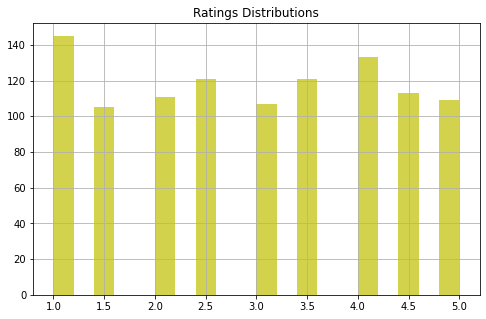

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(ratings["rating"], color="y", bins=20, alpha=0.7)
plt.title("Ratings Distributions")
plt.grid()
plt.show()

* Distribution of the number of course views

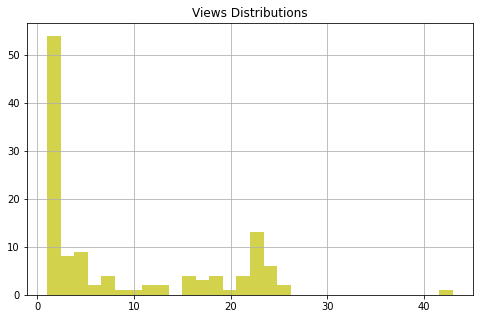

In [7]:
import matplotlib.pyplot as plt


freq = ratings.groupby("course")["rating"].agg(["size"]).values[:, 0]
plt.figure(figsize=(8, 5))
plt.hist(freq, color="y", bins=30, alpha=0.7)
plt.title("Views Distributions")
plt.grid()
plt.show()

### Target Definition

In this solution I assume that ratings greater or equal to 4 could be considered as "positive" reactions on course and ratings less than 4 are "negative".

In [8]:
ratings["target"] = (ratings["rating"] >= 4).astype("int")

### Metric Choice

Average precision at top 5 courses seems to be a "classic" choice for this ranking task.

In [9]:
from sklearn.metrics import average_precision_score

### 1. Naive Approach

Baseline approach is to choose courses with highest ratings.  
Courses with less than 5 viewers are dropped as we do not have enough information about them.

In [10]:
from tools import get_best_courses

get_best_courses(ratings)

course      mean
0                 Mehr Tempo durch Digitalisierung  3.687500
1  Lerntransfer für Qualität einhalten und fördern  3.571429
2                                         Facebook  3.416667
3              Basiswissen Digitale Transformation  3.375000
4                Produktiv arbeiten im Home-Office  3.312500

In [11]:
ap_list = []

for user in users["username"].unique():
    
    train_mask = ratings["username"] != user
    test_mask = ratings["username"] == user
    
    best_courses = get_best_courses(ratings[train_mask])
    
    y_test = pd.merge(ratings[test_mask], best_courses, on="course")
    y_test = y_test.sort_values("mean", ascending=False)["target"].values
    
    if len(y_test) > 0:
        ap = average_precision_score(y_test, np.ones(shape=y_test.shape))
        ap = 0 if np.isnan(ap) else ap
        ap_list.append(ap)
    
print(f"Mean AP: {np.mean(ap_list)}")

Mean AP: 0.22357723577235772


### 2. Add Industry variable

Adding information about industry may be considered as minor improvement of the previous approach.

In [12]:
from tools import get_best_courses_by_industry

get_best_courses_by_industry(ratings).sort_values(["industry", "mean"], ascending=False)

course  \
15                         Change Management Training   
17                              SCRUM – Der Überblick   
18  Vertiefung: Advanced Analytics mit Machine Lea...   
16    Neue Wege gehen - Alte Wege neu gehen - KOMPAKT   
19  Wie Du Change in Deinem Unternehmen etablierst...   
12              Qualitätssicherung - heute und morgen   
10                Basiswissen Digitale Transformation   
14  Wie Du Change in Deinem Unternehmen etablierst...   
13                      Virtual Teams - Communication   
11            Lerntransfer für Qualität kontrollieren   
6   DIN EN ISO 9001: 2015 Überblick - Online-Training   
5                                          Arbeit 4.0   
7                  Lerntransfer für Daten analysieren   
8                   Produktiv arbeiten im Home-Office   
9                             Überzeugend Formulieren   
4        Lerntransfer für Arbeitssicherheit einhalten   
2                                            Facebook   
3   Gesundes Arbeiten im Büro: Der ergnomische Bil...   
1                 Basiswissen Digitale Transformation   
0                                          Arbeit 4.0   

                                 industry      mean  
15                    Metall & Elektronik  3.750000  
17                    Metall & Elektronik  3.714286  
18                    Metall & Elektronik  3.666667  
16                    Metall & Elektronik  3.500000  
19                    Metall & Elektronik  3.500000  
12                                 Handel  4.071429  
10                                 Handel  4.000000  
14                                 Handel  3.800000  
13                                 Handel  3.750000  
11                                 Handel  3.714286  
6   Finanzen, Versicherungen & Immobilien  4.000000  
5   Finanzen, Versicherungen & Immobilien  3.750000  
7   Finanzen, Versicherungen & Immobilien  3.687500  
8   Finanzen, Versicherungen & Immobilien  3.642857  
9   Finanzen, Versicherungen & Immobilien  3.625000  
4                        Energie & Umwelt  5.000000  
2                        Energie & Umwelt  4.000000  
3                        Energie & Umwelt  4.000000  
1                        Energie & Umwelt  3.500000  
0                        Energie & Umwelt  3.428571

In [13]:
ap_list = []

for user in users["username"].unique():
    
    train_mask = ratings["username"] != user
    test_mask = ratings["username"] == user
    
    best_courses = get_best_courses_by_industry(ratings[train_mask])
    
    y_test = pd.merge(ratings[test_mask], best_courses, on=["course", "industry"])
    y_test = y_test.sort_values("mean", ascending=False)["target"].values
    
    if len(y_test) > 0:
        ap = average_precision_score(y_test, np.ones(shape=y_test.shape))
        ap = 0 if np.isnan(ap) else ap
        ap_list.append(ap)
    
print(f"MAP: {np.mean(ap_list)}")

MAP: 0.191869918699187


### 3. Simple Model

Data preprocessing includes the following steps: 

1. Transforming chategorical features (industry/position/) into dummy columns

2. Adding simple statistics (like mean/max/min rating of the course) into features set

3. Standard scaling of features as far as we use Logistic Regression

Model choice: 

1. Logistic Regression

Why Logistic Regression? The dataset is not large enough, so the main risk is to get overfitting. That's the main reason why I prefer not to use more "complex" models here.

Validation:

1. Validation is proceeded via LOO technic.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tools import PeersFeatureExtractor, add_dummy_variables

dataset = copy(ratings)
dataset = add_dummy_variables(dataset, columns=["position", "department", "industry"])

pfe = PeersFeatureExtractor()
lr = LogisticRegression()
ss = StandardScaler()


ap_list = []

for user in users["username"].unique():
    
    train_mask = dataset["username"] != user
    test_mask = dataset["username"] == user
    
    train = dataset[train_mask]
    test = dataset[test_mask]
    
    train = pfe.fit_transform(train)
    test = pfe.transform(test)
    
    features = [col for col in train.columns 
                if (col.startswith(("course_", "position_", "department_", "industry_")))
               ]
    
    X_train, y_train = train[features], train["target"]
    X_test, y_test = test[features], test["target"]
    
    
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    lr.fit(X_train, y_train)
    
    y_proba = lr.predict_proba(X_test)[:, 1]
    y_pred = lr.predict(X_test)
    
    best_courses = np.argsort(y_proba)[::-1][:5]
    
    ap = average_precision_score(y_test[best_courses], [1, 1, 1, 1, 1])
    ap = 0 if np.isnan(ap) else ap
    ap_list.append(ap)
    
print(f"Mean AP: {np.mean(ap_list)}")

Mean AP: 0.2604651162790698


### Final Decision

* Load test users data.

In [15]:
test = pd.read_excel("data/Dataset.xlsx", sheet_name="Q", engine="openpyxl")
test = test.rename(columns={col: col.lower().replace(" ", "_") for col in test.columns})

test["group"] = "test"

* Cross join users from test with the appropriate courses, so that they form user-course pairs for scoring.

An important thing is to choose only between courses watched by the customers from the same industry and on the same position.  
Also let's choose only from courses with sufficient number of viewers (>=2), otherwise rarely watched courses with high ratings might be recommended.

In [16]:
courses_list = dataset.groupby(["course", "industry", "position"], as_index=False)["rating"].agg(["size"]).reset_index()
courses_list = courses_list[courses_list["size"] >= 2]

test = pd.merge(test, courses_list, on=["industry", "position"])

* Fitting the model on the whole dataset and choosing top-5 courses for test users

In [17]:
dataset = copy(ratings)
dataset["group"] = "train"

dataset = pd.concat((dataset, test))
dataset = add_dummy_variables(dataset, columns=["position", "department", "industry"])

train = dataset[dataset["group"] == "train"]
test = dataset[dataset["group"] == "test"]

pfe = PeersFeatureExtractor()
lr = LogisticRegression()
ss = StandardScaler()

train = pfe.fit_transform(train)
features = [col for col in train.columns 
            if (col.startswith(("course_", "position_", "department_", "industry_")))]

X_train, y_train = train[features], train["target"]
X_train = ss.fit_transform(X_train)
    
lr.fit(X_train, y_train)

for user in test["username"].unique():
    
    print(f"==== {user} ====")
    
    X_test = pfe.transform(test[test["username"] == user])[features]
    X_test = ss.transform(X_test)
    
    y_proba = lr.predict_proba(X_test)[:, 1]
    
    top_courses = np.argsort(y_proba)[::-1][:5]
    top_courses = test.loc[test["username"] == user, "course"].iloc[best_courses].values
    
    for course in top_courses:
        print(course)
    
    print()

==== Franke ====
Die sieben Grundsätze von Qualitätsmanagement
Lerntransfer für Daten analysieren
Lerntransfer für Hybride Arbeitskultur
Fit & Gesund im Job
DIN EN ISO 9001: 2015 Umgang mit Risiken - Online-Training

==== Marie ====
Digitale Disruption verstehen
Lerntransfer für Anpassungsfähigkeit fördern
Lerntransfer für Digitale Rhetorik
Fit & Gesund im Job
Arbeitschutz im Büro

==== Agnes ====
Digitale Disruption verstehen
Lerntransfer für Anpassungsfähigkeit fördern
Lerntransfer für Digitale Rhetorik
Fit & Gesund im Job
Arbeitschutz im Büro

==== David ====
Basiswissen Digitale Transformation
Lerntransfer für Arbeitssicherheit einhalten
Lerntransfer für Innovationen vorantreiben
Die sieben Grundsätze von Qualitätsmanagement
Arbeit 4.0

==== Bärbel ====
Facebook
Lerntransfer für New Work
Produktiv arbeiten im Home-Office
Lerntransfer für Agiles Arbeiten
Digitale Disruption verstehen

